# Complete Beginner's Guide to Topological Data Analysis  
### A Step-by-Step Walkthrough  
**Ali Al-Barkawi, Montader Alasady**

This guide provides a beginner-friendly walkthrough of topological data analysis using persistent homology and the Mapper algorithm.  
We use six points on a circle to show how to detect loops and create graph-based summaries.


## Step 1: Plot Your Points

We use 6 points on a circle:

A = (1, 0)  
B = (0.5, 0.87)  
C = (-0.5, 0.87)  
D = (-1, 0)  
E = (-0.5, -0.87)  
F = (0.5, -0.87)

Let's plot them.


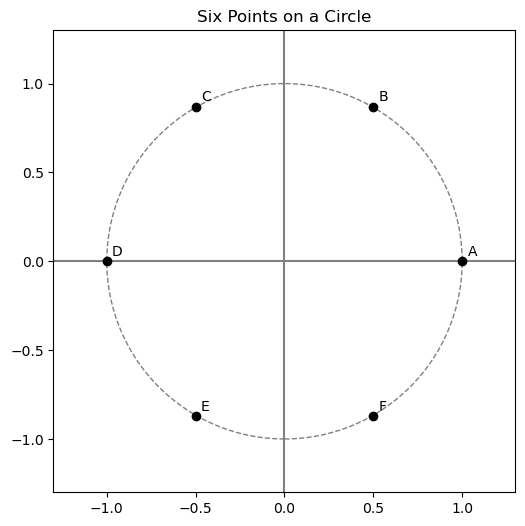

In [30]:
import numpy as np
import matplotlib.pyplot as plt

points = {
    "A": (1,0),
    "B": (0.5,0.87),
    "C": (-0.5,0.87),
    "D": (-1,0),
    "E": (-0.5,-0.87),
    "F": (0.5,-0.87),
}

plt.figure(figsize=(6,6))
plt.axhline(0, color='gray')
plt.axvline(0, color='gray')

for label, (x,y) in points.items():
    plt.plot(x, y, 'ko')
    plt.text(x+0.03, y+0.03, label)

circle = plt.Circle((0,0), 1, color='gray', fill=False, linestyle='--')
plt.gca().add_patch(circle)

plt.xlim(-1.3, 1.3)
plt.ylim(-1.3, 1.3)
plt.gca().set_aspect('equal')
plt.title("Six Points on a Circle")
plt.show()


## Step 2: Calculate Distances Between Points

We compute the Euclidean distances for all pairs.


In [8]:
import pandas as pd
from math import dist

labels = list(points.keys())
dist_matrix = pd.DataFrame(index=labels, columns=labels)

for a in labels:
    for b in labels:
        dist_matrix.loc[a,b] = round(dist(points[a], points[b]), 2)

dist_matrix


,A,B,C,D,E,F
A,0.0,1.0,1.73,2.0,1.73,1.0
B,1.0,0.0,1.0,1.73,2.01,1.74
C,1.73,1.0,0.0,1.0,1.74,2.01
D,2.0,1.73,1.0,0.0,1.0,1.73
E,1.73,2.01,1.74,1.0,0.0,1.0
F,1.0,1.74,2.01,1.73,1.0,0.0


## Step 3: Filtration at ε = 0

- No edges, only 6 isolated points  
- H₀ = 6 components  
- H₁ = 0 loops  


## Step 4: Filtration at ε = 1

Connect points with distance ≤ 1 (neighbors on the circle).  
This forms a **hexagon**, producing **one loop**.


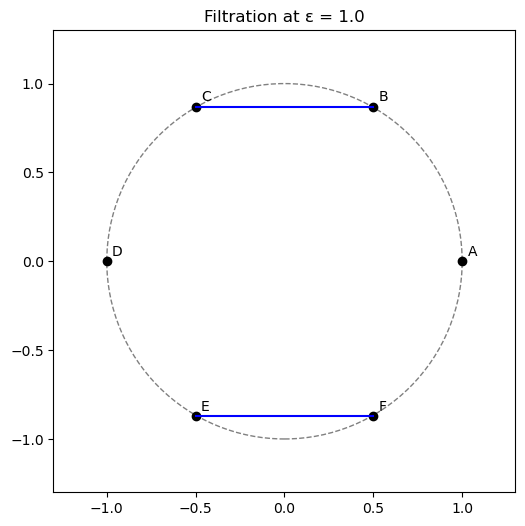

In [11]:
import itertools

def draw_edges(threshold):
    plt.figure(figsize=(6,6))
    plt.title(f"Filtration at ε = {threshold}")
    plt.gca().set_aspect('equal')

    # draw circle
    circle = plt.Circle((0,0), 1, color='gray', fill=False, linestyle='--')
    plt.gca().add_patch(circle)

    # draw points
    for label, (x,y) in points.items():
        plt.plot(x,y,'ko')
        plt.text(x+0.03,y+0.03,label)

    # draw edges below threshold
    for a,b in itertools.combinations(points.keys(),2):
        d = dist(points[a], points[b])
        if d <= threshold + 1e-9:
            x1,y1 = points[a]
            x2,y2 = points[b]
            plt.plot([x1,x2],[y1,y2],'b-')

    plt.xlim(-1.3,1.3)
    plt.ylim(-1.3,1.3)
    plt.show()

draw_edges(1.0)


## Step 5: Filtration at ε = 1.73

Edges of length √3 appear, filling in triangles.  
The hexagon loop is **killed** at this scale.

- H₁ = 0 (loop dies)


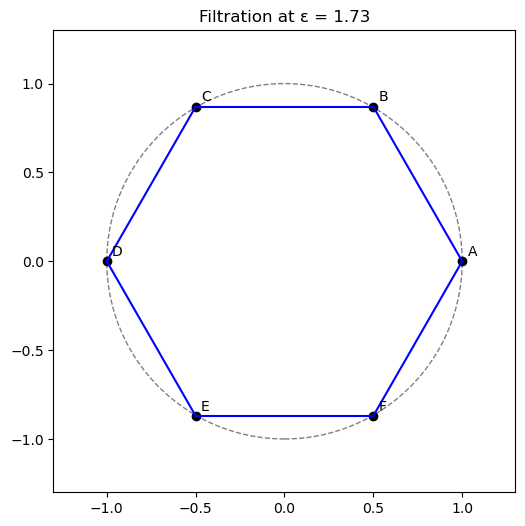

In [13]:
draw_edges(1.73)

## Step 6: Barcode Diagram

The loop (H₁) is born at ε = 1 and dies at ε = √3 ≈ 1.73.


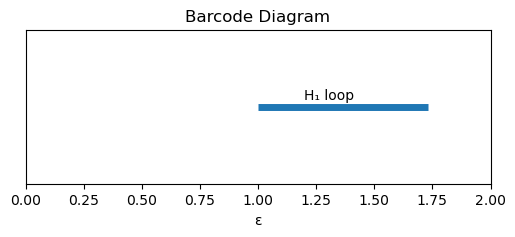

In [15]:
plt.figure(figsize=(6,2))
plt.hlines(1, 1, 1.73, linewidth=5)
plt.text(1.2, 1.05, "H₁ loop")

plt.xlim(0,2)
plt.ylim(0.5,1.5)
plt.xlabel("ε")
plt.yticks([])
plt.title("Barcode Diagram")
plt.show()


## Step 7: Select Lens Function (x-coordinate)

We record each point's x-value and view data through it.


In [23]:
xs = {label: p[0] for label,p in points.items()}
xs


{'A': 1, 'B': 0.5, 'C': -0.5, 'D': -1, 'E': -0.5, 'F': 0.5}

## Step 8: Create Overlapping Intervals

We use:

- I₁ = [-1.0, -0.2]  
- I₂ = [-0.6, 0.6]  
- I₃ = [0.2, 1.0]  

We assign each point to all intervals that contain its x-value.


In [22]:
I1 = [p for p in xs if -1.0 <= xs[p] <= -0.2]
I2 = [p for p in xs if -0.6 <= xs[p] <= 0.6]
I3 = [p for p in xs if  0.2 <= xs[p] <= 1.0]

I1, I2, I3


(['C', 'D', 'E'], ['B', 'C', 'E', 'F'], ['A', 'B', 'F'])

## Step 9: Clustering Within Each Interval

We cluster points using distance threshold 1.1.


In [24]:
def cluster_points(pt_list, threshold=1.1):
    # simple connected components clustering
    remaining = set(pt_list)
    clusters = []
    while remaining:
        seed = remaining.pop()
        stack = [seed]
        comp = {seed}

        while stack:
            u = stack.pop()
            for v in list(remaining):
                if dist(points[u], points[v]) <= threshold:
                    remaining.remove(v)
                    comp.add(v)
                    stack.append(v)
        clusters.append(comp)
    return clusters

clusters_I1 = cluster_points(I1)
clusters_I2 = cluster_points(I2)
clusters_I3 = cluster_points(I3)

clusters_I1, clusters_I2, clusters_I3


([{'C', 'D', 'E'}], [{'E', 'F'}, {'B', 'C'}], [{'A', 'B', 'F'}])

## Step 10: Build the Mapper Graph

We connect clusters if they share at least one point.


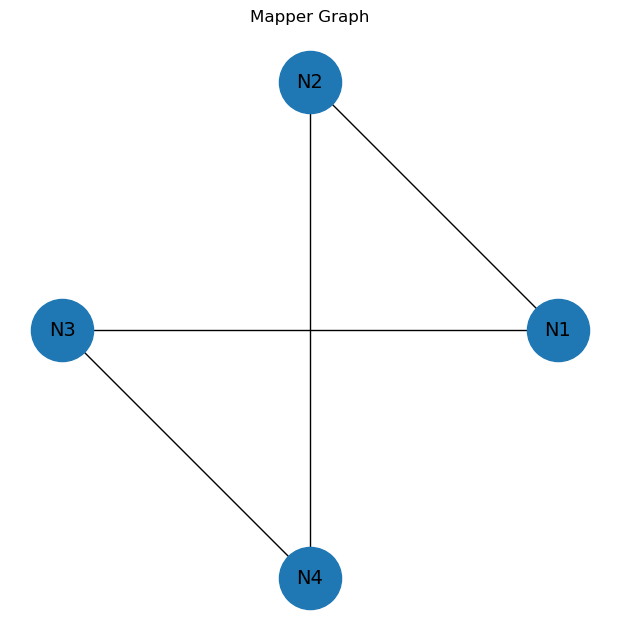

NodeDataView({'N1': {'members': ['C', 'D', 'E']}, 'N2': {'members': ['E', 'F']}, 'N3': {'members': ['B', 'C']}, 'N4': {'members': ['A', 'B', 'F']}})

In [28]:
import networkx as nx

clusters = [
    clusters_I1[0],         # N1
    clusters_I2[0],         # N2
    clusters_I2[1],         # N3
    clusters_I3[0],         # N4
]

G = nx.Graph()
for i,c in enumerate(clusters):
    G.add_node(f"N{i+1}", members=sorted(c))

# connect nodes that share at least 1 point
for i in range(len(clusters)):
    for j in range(i+1,len(clusters)):
        if clusters[i].intersection(clusters[j]):
            G.add_edge(f"N{i+1}", f"N{j+1}")

pos = nx.circular_layout(G)
plt.figure(figsize=(6,6))
nx.draw(G, pos, with_labels=True, node_size=2000, font_size=14)
plt.title("Mapper Graph")
plt.show()

G.nodes(data=True)


# What Did We Discover?

## Persistent Homology
- One loop appears at ε=1 and disappears at ε≈1.73  
- This indicates a **strong circular structure** in the data  

## Mapper Algorithm
- The mapper graph forms a **4-cycle**, again revealing circular structure  

Both algorithms independently detect the underlying topology of the dataset.
